# Cross-tissue

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import os,sys
import glob
import scanpy as sc 
import pandas as pd
import numpy as np
import milopy
import scipy
import anndata

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sns.set_context('talk')
from matplotlib.pyplot import rc_context

import milopy
import milopy.core as milo

In [6]:
# from oor_benchmark.metrics import auprc, FDR_TPR_FPR

In [7]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [8]:
%load_ext rpy2.ipython

In [9]:
%%R
library(tidyverse)

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to create bus connection: Host is down


In [10]:
## Some utils

def _plot_nhood_sizes(adata, bins=50, **kwargs):
    plt.hist(np.array(adata.obsm['nhoods'].sum(0)).ravel(), bins=bins, **kwargs);
    plt.xlabel('# cells');plt.ylabel('# nhoods');
    
def get_nhood_adata(adata):
    return(adata.uns['nhood_adata'])

def get_cells_from_nhood(adata, i):
    return((adata.obsm['nhoods'][:,i].toarray() == 1).flatten())

def remove_x_axis(ax):
    ax.xaxis.set_major_locator(matplotlib.ticker.NullLocator());
    ax.set_xlabel('');

def remove_y_axis(ax):
    ax.yaxis.set_major_locator(matplotlib.ticker.NullLocator());
    ax.set_ylabel('');
    
def make_ct_label(label):
    return(' '.join(label.split('_')))

In [26]:
sns.color_palette('Paired')

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

In [28]:
pal = sns.color_palette('Paired').as_hex()
pal[2]

'#b2df8a'

In [22]:
## Define color palette
pal = sns.color_palette('Paired').as_hex()
design_palette = {'ACR':pal[3], 'CR scArches':pal[7], 'AR':pal[9], 'CR scVI':pal[6]}
design_palette_df = pd.DataFrame(design_palette.values(), index =design_palette.keys() )
design_palette_df.columns = ['color']

In [23]:
%%R -i design_palette_df
design_palette <- setNames(design_palette_df$color, rownames(design_palette_df))

scale_color_design <- function(){
    scale_color_manual(values=design_palette, name='design')
}

scale_fill_design <- function(){
    scale_color_manual(values=design_palette, name='design')
}

In [102]:
figdir = '/home/jovyan/mount/gdrive/diff2atlas/figures/crosstissue/'
if not os.path.exists(figdir):
    os.mkdir(figdir)
    
sc.settings.figdir = figdir

### Prep case-control dataset

See `HLCA_prep_designs.ipynb`

In [302]:
adata = sc.read_h5ad('/lustre/scratch117/cellgen/team205/ed6/HLCA/Kaminski_2020_emb_LCAv2.annotated.with_counts.h5ad')

In [303]:
## Subset to healthy patients
adata = adata[adata.obs['Disease_Identity'] == 'Control'].copy()

In [304]:
## Remove samples with less than 1k cells 
np.random.seed(42)
n_cells = adata.obs['Library_Identity'].value_counts()
keep_samples = n_cells.index[n_cells >= 1000].astype('str')

## Sample 1k cells per sample
keep_obs = []
for s in keep_samples:
    keep_obs_s = np.random.choice(adata[adata.obs['Library_Identity'] == s].obs_names.tolist(), size=1000, replace=False)
    keep_obs.extend(keep_obs_s)

In [305]:
adata = adata[keep_obs].copy()

#### Pick cell types for simulation

In [306]:
oor_cts = ['Alveolar macrophages', 'NK cells', 'Multiciliated (non-nasal)', 'Fibroblasts', 'Lymphatic EC', 'DC2']

In [307]:
adata.obs['cell_annotation'] = ['Lymphatic EC' if x.startswith('Lymphatic EC') else x for x in adata.obs['Celltype_HLCA']]
adata.obs['sample_id'] = adata.obs['Library_Identity']

In [308]:
adata.obs['cell_annotation'] = ['Fibroblasts' if 'fibroblasts' in x else x for x in adata.obs['cell_annotation']]

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


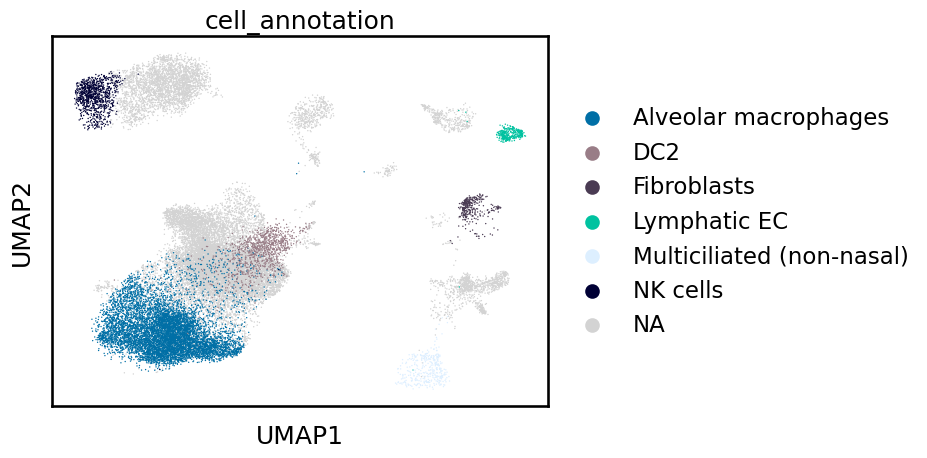

In [309]:
sc.pl.umap(adata, color='cell_annotation', groups=oor_cts)

#### Split

In [310]:
from oor_benchmark.datasets.simulation import simulate_query_reference
from oor_benchmark.api import check_dataset

In [311]:
split_seed = 2025
np.random.seed(split_seed)
all_samples = adata.obs['sample_id'].unique()
query_samples = np.random.choice(all_samples, size=int(len(all_samples)/2), replace=False)
ctrl_samples = all_samples[~all_samples.isin(query_samples)]

In [312]:
adata[adata.obs['sample_id'].isin(query_samples)].obs['cell_annotation'].value_counts().loc[oor_cts]

Alveolar macrophages         3819
NK cells                      483
Multiciliated (non-nasal)     172
Fibroblasts                   172
Lymphatic EC                  165
DC2                           603
Name: cell_annotation, dtype: int64

/tmp/ipykernel_2198/3866835247.py:3: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  ct_abundance_adata = anndata.AnnData(X=conf_mat.T)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


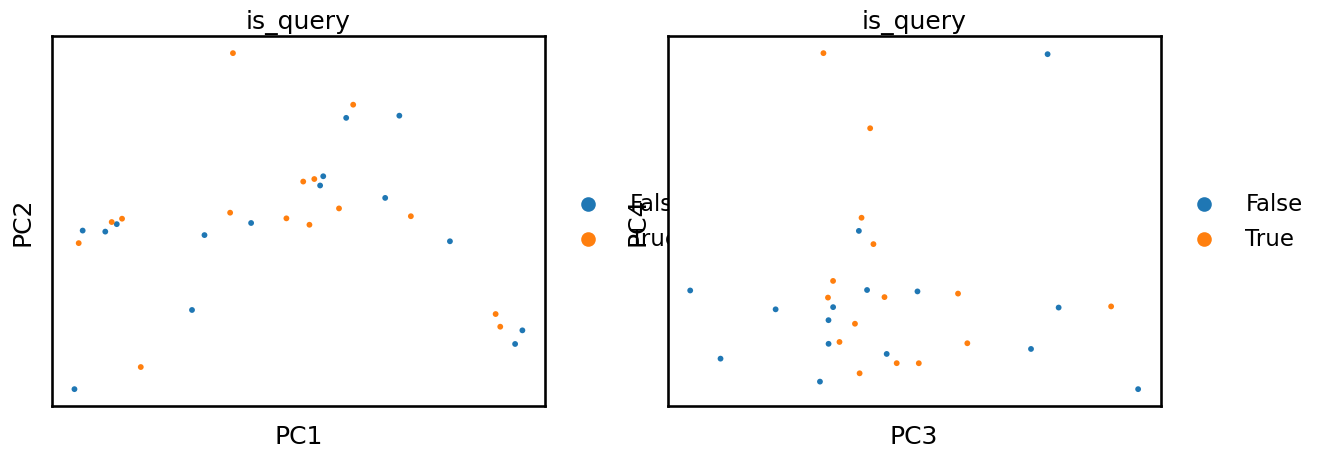

In [313]:
## Check split
conf_mat = sc.metrics.confusion_matrix('Celltype_HLCA','sample_id', adata.obs, normalize=False)
ct_abundance_adata = anndata.AnnData(X=conf_mat.T)
sc.pp.pca(ct_abundance_adata)

ct_abundance_adata.obs['is_query'] = ct_abundance_adata.obs_names.isin(query_samples)
ct_abundance_adata.obs['is_query'] = ct_abundance_adata.obs['is_query'].astype(str)

sc.pl.pca(ct_abundance_adata, color='is_query', size=70, components=['1,2', '3,4'])

In [314]:
outdir = '/lustre/scratch117/cellgen/team205/ed6/OOR_benchmark_lung/'
if not os.path.exists(outdir):
    os.mkdir(outdir)

In [316]:
adata.obs['cell_type_clean'] = adata.obs['cell_annotation'].str.replace(" ", '_').str.replace("-", '_').str.replace(",", '').str.replace(")", '').str.replace("(", '')
oor_cts = [x.replace(" ", '_').replace("-", '_').replace(",", '').replace(")", '').replace("(", '') for x in oor_cts]

annotation_col = 'cell_type_clean'

for ct in oor_cts:
    print(ct)
    adata_s = adata.copy()
    adata_s = simulate_query_reference(
        adata_s, query_annotation=[ct],
        annotation_col=annotation_col, 
        batch_col='sample_id',
        query_batch = query_samples.tolist(),
        ctrl_batch = ctrl_samples.tolist(),
    )

    # Save intermediate files
    sim_id = f"Kaminski2020_lung_{annotation_col}{ct}_seed{split_seed}/"
    if not os.path.exists(outdir + sim_id):
        os.mkdir(outdir + sim_id)

    # Run embedding and differential abundance testing
    if 'X_scVI' in adata_s.obsm:
        del adata_s.obsm['X_scVI']
        
    assert check_dataset(adata_s)
    adata_s.write_h5ad(outdir + sim_id + 'query_ctrl_adata.h5ad')

/tmp/ipykernel_2198/2231387810.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  adata.obs['cell_type_clean'] = adata.obs['cell_annotation'].str.replace(" ", '_').str.replace("-", '_').str.replace(",", '').str.replace(")", '').str.replace("(", '')


Alveolar_macrophages
NK_cells
Multiciliated_non_nasal
Fibroblasts
Lymphatic_EC
DC2


In [317]:
simdirs = [outdir + x for x in os.listdir(outdir) if x.startswith("Kaminski")]

In [318]:
for s in simdirs:
    adata = sc.read_h5ad(s + '/query_ctrl_adata.h5ad', backed=True)
    adata.var['gene_name'] = adata.var_names.copy()
    adata.var_names = adata.var['Ensembl_GeneID'].copy()
    adata.write_h5ad()

## Prep good atlas

Download HLCA model following this https://docs.scvi-tools.org/en/stable/tutorials/notebooks/query_hlca_knn.html


In [19]:
# RUN ON GPU ENVIRONMENT
# import scvi
# from scvi.hub import HubModel
# from scvi.model.utils import mde
# from anndata import AnnData


# hubmodel = HubModel.pull_from_huggingface_hub("scvi-tools/human-lung-cell-atlas")
# model = hubmodel.model
# model.save("/home/jupyter/mount/gdrive/diff2atlas/scratch117_copy/HLCA_model_huggingface", save_anndata=True)

## Prep cross-organ atlas

Data from Tabula sapiens, downloaded from figshare ([here](https://figshare.com/articles/dataset/Tabula_Sapiens_release_1_0/14267219))


In [80]:
from anndata.experimental import read_elem

In [81]:
ts_file = "/lustre/scratch126/cellgen/cellgeni/alexp/Tabula_Sapiens/original_counts/TabulaSapiens.h5ad"
import h5py
f = h5py.File(ts_file, 'r')

In [82]:
X_counts = read_elem(f['layers']['decontXcounts'])
obs_df = read_elem(f['obs'])
var_df = read_elem(f['var'])

In [110]:
scvi_setup = read_elem(f['uns']['_scvi'])

In [111]:
scvi_setup

{'categorical_mappings': {'_scvi_batch': {'mapping': array(['TSP1smartseq2', 'TSP2smartseq2', 'TSP3smartseq2', 'TSP4smartseq2',
          'TSP5smartseq2', 'TSP6smartseq2', 'TSP7smartseq2', 'TSP8smartseq2',
          'TSP9smartseq2', 'TSP10smartseq2', 'TSP11smartseq2',
          'TSP12smartseq2', 'TSP13smartseq2', 'TSP110X', 'TSP210X',
          'TSP310X', 'TSP410X', 'TSP510X', 'TSP610X', 'TSP710X', 'TSP810X',
          'TSP910X', 'TSP1010X', 'TSP1110X', 'TSP1210X', 'TSP1410X',
          'TSP1510X'], dtype=object),
   'original_key': 'donor_method'},
  '_scvi_labels': {'mapping': array([0]), 'original_key': '_scvi_labels'}},
 'data_registry': {'X': {'attr_key': 'decontXcounts', 'attr_name': 'layers'},
  'batch_indices': {'attr_key': '_scvi_batch', 'attr_name': 'obs'},
  'labels': {'attr_key': '_scvi_labels', 'attr_name': 'obs'},
  'local_l_mean': {'attr_key': '_scvi_local_l_mean', 'attr_name': 'obs'},
  'local_l_var': {'attr_key': '_scvi_local_l_var', 'attr_name': 'obs'}},
 'scvi_versio

In [83]:
adata_ts = anndata.AnnData(X = X_counts, obs=obs_df, var=var_df)
adata_ts.var_names = adata_ts.var['ensemblid'].values
adata_ts.write_h5ad('/lustre/scratch117/cellgen/team205/ed6/OOR_benchmark_lung/TabulaSapiens_clean.h5ad')

In [94]:
## Exclude smartseq2 samples
adata_ts = adata_ts[adata_ts.obs['method'] != 'smartseq2'].copy()

In [112]:
adata_ts.write_h5ad('/lustre/scratch117/cellgen/team205/ed6/OOR_benchmark_lung/TabulaSapiens_clean.h5ad')

In [91]:
adata_ts = sc.read_h5ad('/lustre/scratch117/cellgen/team205/ed6/OOR_benchmark_lung/TabulaSapiens_clean.h5ad', backed=True)

In [97]:
adata_ts

AnnData object with n_obs × n_vars = 456101 × 58870 backed at '/lustre/scratch117/cellgen/team205/ed6/OOR_benchmark_lung/TabulaSapiens_clean.h5ad'
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'

In [99]:
adata_ts.obs['organ_tissue'].nunique()

24

Train scVI model

In [158]:
model_vars = sc.read_h5ad('/lustre/scratch117/cellgen/team205/ed6/OOR_benchmark_lung/model_atlas/adata.h5ad', backed=True).var

In [173]:
model_vars['ensID_cut'] = [x[0] for x in model_vars.index.str.split('.')]


1924

## Run design comparison

## Parse results

In [1]:
from oor_benchmark.metrics import FDR_TPR_FPR
from oor_benchmark.metrics import auprc
from oor_benchmark.methods.scArches_milo import run_milo

def harmonize_output(adata, signif_alpha=0.1):
#     if adata.isbacked:
#         sample_adata = adata.uns['nhood_adata'].to_memory().T
#     else:
    sample_adata = adata.uns["nhood_adata"].T.copy()
    sample_adata.var["OOR_score"] = sample_adata.var["logFC"].copy()
    sample_adata.var["OOR_signif"] = (
        ((sample_adata.var["SpatialFDR"] < signif_alpha) &
         (sample_adata.var["logFC"] > 0)).astype(int).copy()
    )
    sample_adata.varm["groups"] = adata.obsm["nhoods"].T
    adata.uns["sample_adata"] = sample_adata.copy()

def read_oor_design_output(simdir, ref_design, population_obs):
    perturb_pop = simdir.split(population_obs)[1].split('_seed')[0]
    print(f'Reading {perturb_pop}\n')
    h5ad_file = simdir + f'/{ref_design}_design.h5ad'
    adata = milopy.utils.read_milo_adata(
                h5ad_file, backed=False)
    adata.obs['OOR_state_name'] = perturb_pop
    return(adata)

def parse_design(adata, ref_design):
    if 'sample_adata' not in adata.uns:
        harmonize_output(adata)
    perturb_pop = adata.obs['OOR_state_name'].unique()[0]
    tpr_df = FDR_TPR_FPR.FDR_TPR_FPR(adata)
    auprc_df = auprc.auprc(adata, return_curve=True)
    nhoods_df = adata.uns['sample_adata'].var.copy()
    tpr_df['design'] = ref_design
    tpr_df['OOR_state_name'] = perturb_pop
    auprc_df['design'] = ref_design
    auprc_df['OOR_state_name'] = perturb_pop
    nhoods_df['design'] = ref_design
    nhoods_df['OOR_state_name'] = perturb_pop
    return(nhoods_df, tpr_df, auprc_df)

Global seed set to 0


In [2]:
outdir = '/lustre/scratch117/cellgen/team205/ed6/OOR_benchmark_lung/'

In [3]:
# for d in [x for x in os.listdir(outdir) if x.startswith("Kaminski")]:
for d in [x for x in os.listdir(outdir) if x.startswith("Kaminski") and x.endswith('seed2025')]:    
    simdir = outdir + d
    nhoods_df_all = pd.DataFrame()
    tpr_df_all = pd.DataFrame()
    auprc_df_all = pd.DataFrame()

    for d in ['HLCA', "CR", "TabulaSapiens"]:
        try:
            adata = read_oor_design_output(simdir, d, population_obs='cell_type_clean')
        except:
            continue
        if adata is not None:
            nhoods_df, tpr_df, auprc_df = parse_design(adata, d)
            nhoods_df_all = pd.concat([nhoods_df_all, nhoods_df])
            tpr_df_all = pd.concat([tpr_df_all, tpr_df])
            auprc_df_all = pd.concat([auprc_df_all, auprc_df])

    # print(auprc_df_all.head())
    nhoods_df_all.to_csv(simdir + f'/nhoods_obs.csv')
    tpr_df_all.to_csv(simdir + f'/TPR_res.csv')
    auprc_df_all.to_csv(simdir + f'/AUPRC_res.csv')

NameError: name 'os' is not defined

## Read results

In [39]:
nhoods_df_all = pd.DataFrame()
auprc_df_all = pd.DataFrame()
tpr_df_all = pd.DataFrame()
for d in [x for x in os.listdir(outdir) if x.startswith("Kaminski") and x.endswith('2025')]:
    simdir = outdir + d 
    nh_df = pd.read_csv(f'{simdir}/nhoods_obs.csv', index_col=0)
    tpr_df = pd.read_csv(f'{simdir}/TPR_res.csv', index_col=0)
    auprc_df = pd.read_csv(f'{simdir}/AUPRC_res.csv', index_col=0)
    auprc_df_all = pd.concat([auprc_df_all, auprc_df])
    nhoods_df_all = pd.concat([nhoods_df_all, nh_df])
    tpr_df_all = pd.concat([tpr_df_all, tpr_df])

In [40]:
n_oor_cells = {
'Alveolar_macrophages':         3819,
'NK_cells':                      483,
'Multiciliated_non_nasal':     172,
'Fibroblasts':                   172,
'Lymphatic_EC':                  165,
'DC2':                           603 
}

nhoods_df_all = nhoods_df_all[~nhoods_df_all['OOR_state_name'].isin(["Adventitial_fibroblasts", 'AT2'])]
nhoods_df_all['N_oor_cells'] = [n_oor_cells[x] for x in nhoods_df_all.OOR_state_name]
auprc_df_all = auprc_df_all[~auprc_df_all['OOR_state_name'].isin(["Adventitial_fibroblasts", 'AT2'])]
auprc_df_all['N_oor_cells'] = [n_oor_cells[x] for x in auprc_df_all.OOR_state_name]


In [41]:
%%R -i nhoods_df_all -h 1300 -w 700
## Order by size 
# Alveolar macrophages         3819
# NK cells                      483
# Multiciliated (non-nasal)     172
# Fibroblasts                   172
# Lymphatic EC                  165
# DC2                           603

pl1 <- nhoods_df_all %>%
    mutate(signif=ifelse(SpatialFDR <= 0.1 & logFC > 0, 'signif', NA)) %>%
    arrange(- N_oor_cells) %>%
    mutate(OOR_state_name = str_c(OOR_state_name, '\n(', N_oor_cells, ' OOR cells)')) %>%
    mutate(OOR_state_name = factor(OOR_state_name, levels=unique(OOR_state_name))) %>%
    mutate(design = ifelse(design == 'CR', 'CR scVI\n(no atlas)', 
                          ifelse(design == 'HLCA', 'ACR scArches\n(tissue-specific atlas)', 'ACR scArches\n(cross-tissue atlas)'))) %>%
    ggplot(aes(OOR_score, frac_OOR_cells)) +
    geom_point(size=0.5) +
    ylab('Fraction of OOR cells') +
    xlab('DA logFC') +
    geom_point(data=. %>% filter(!is.na(signif)), color='red') +
    facet_grid(OOR_state_name~design, scales='free_x') +
    theme_bw(base_size=18)

In [47]:
%%R -i auprc_df_all
design_palette <- c(
'CR scVI\n(no atlas)'='#fdbf6f',
   'ACR scArches\n(tissue-specific atlas)'= '#33a02c',
    'ACR scArches\n(cross-tissue atlas)'='#b2df8a'
)


pl2 <- auprc_df_all %>%
distinct(AUPRC, OOR_state_name, no_skill_thresh, design, N_oor_cells) %>%
arrange(- N_oor_cells) %>%
mutate(ct_type = ifelse(OOR_state_name %in% c('DC2', 'Alveolar_macrophages', 'NK_cells'), 'immune', 'stromal')) %>%
mutate(OOR_state_name = str_c(OOR_state_name, '\n(', N_oor_cells, ' OOR cells)')) %>%
mutate(OOR_state_name = factor(OOR_state_name, levels=unique(OOR_state_name))) %>%
mutate(design = ifelse(design == 'CR', 'CR scVI\n(no atlas)', 
                      ifelse(design == 'HLCA', 'ACR scArches\n(tissue-specific atlas)', 'ACR scArches\n(cross-tissue atlas)'))) %>%
ggplot(aes(design, AUPRC, fill=design))+
geom_col() + 
scale_fill_manual(values=design_palette) +
facet_grid(OOR_state_name~., scales='free_x') +
theme_bw(base_size=18) +
theme(axis.text.x=element_blank(), axis.ticks.x=element_blank())

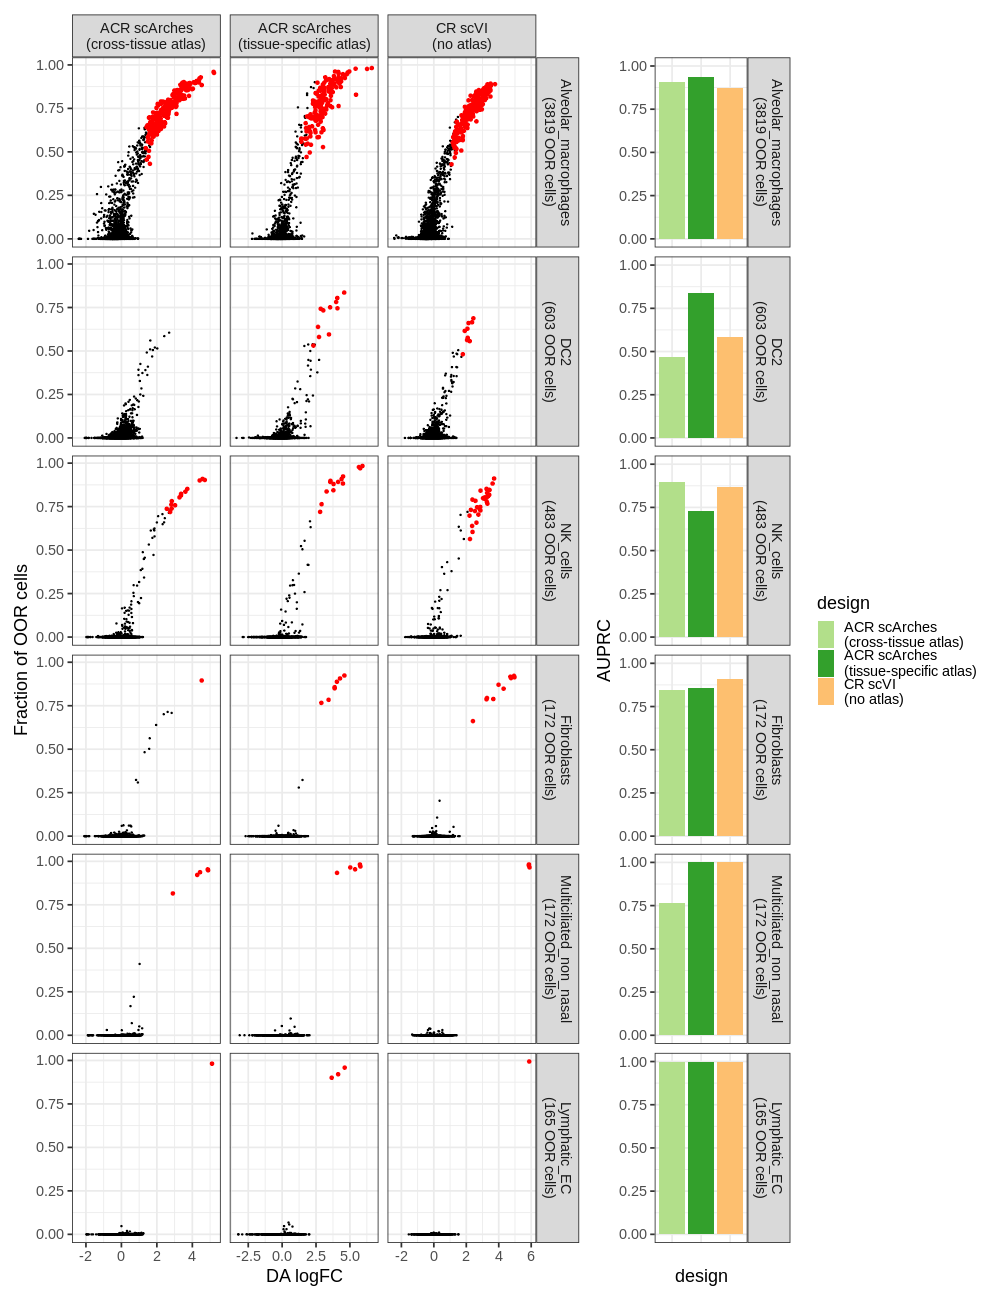

In [52]:
%%R -h 1300 -w 1000 -i figdir
library(patchwork)
(pl1 | pl2 ) + plot_layout(widths=c(5,1)) +
ggsave(paste0(figdir, 'cross_tissue_results.pdf'), width=13, height=16) +
ggsave(paste0(figdir, 'cross_tissue_results.png'), width=13, height=16)

## Make plots for schematic

In [54]:
adata = sc.read_h5ad('/lustre/scratch117/cellgen/team205/ed6/HLCA/Kaminski_2020_emb_LCAv2.annotated.with_counts.h5ad')

In [55]:
## Subset to healthy patients
adata = adata[adata.obs['Disease_Identity'] == 'Control'].copy()

In [56]:
## Remove samples with less than 1k cells 
np.random.seed(42)
n_cells = adata.obs['Library_Identity'].value_counts()
keep_samples = n_cells.index[n_cells >= 1000].astype('str')

## Sample 1k cells per sample
keep_obs = []
for s in keep_samples:
    keep_obs_s = np.random.choice(adata[adata.obs['Library_Identity'] == s].obs_names.tolist(), size=1000, replace=False)
    keep_obs.extend(keep_obs_s)

In [57]:
adata = adata[keep_obs].copy()

In [60]:
sc.pp.neighbors(adata, use_rep='X_scVI', n_neighbors=30)

2023-02-10 15:35:55.804975: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/R/lib:/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/java-8-openjdk-amd64/jre/lib/amd64/server:/usr/lib/R/lib:/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/java-8-openjdk-amd64/jre/lib/amd64/server
2023-02-10 15:35:55.845357: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-10 15:35:57.552743: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/R/lib:/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/java-8-openjdk-amd64/jre/lib/amd64/server:/us

In [61]:
sc.tl.umap(adata)

In [63]:
oor_cts = ['Alveolar macrophages', 'NK cells', 'Multiciliated (non-nasal)', 'Fibroblasts', 'Lymphatic EC', 'DC2']
adata.obs['cell_annotation'] = ['Lymphatic EC' if x.startswith('Lymphatic EC') else x for x in adata.obs['Celltype_HLCA']]
adata.obs['sample_id'] = adata.obs['Library_Identity']
adata.obs['cell_annotation'] = ['Fibroblasts' if 'fibroblasts' in x else x for x in adata.obs['cell_annotation']]

PosixPath('figures')

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


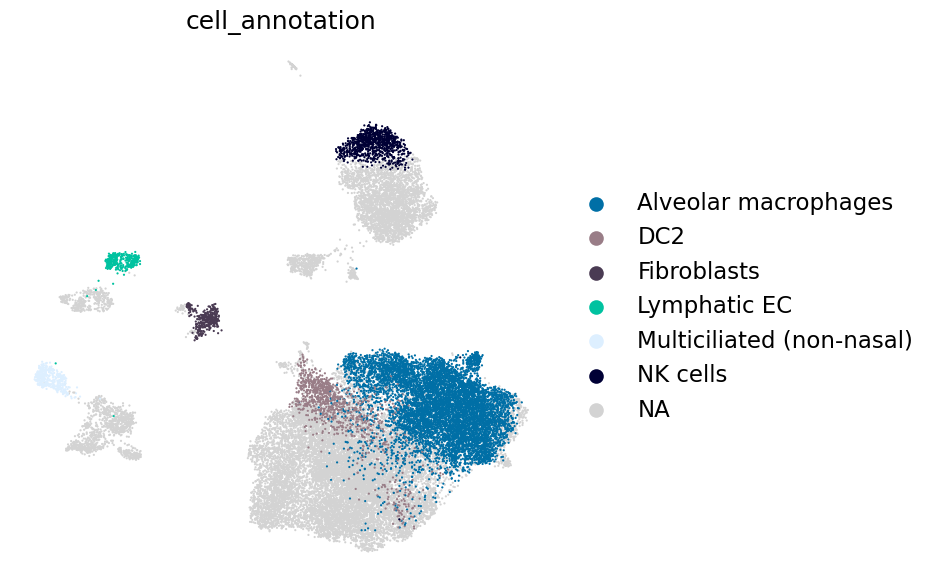

In [103]:
plt.rcParams['figure.figsize'] = [7,7]
sc.pl.umap(adata, color='cell_annotation', groups=oor_cts, frameon=False, size=10,
          save='example_cts.png')

In [78]:
simdirs = [outdir + x for x in os.listdir(outdir) if x.startswith("Kaminski")]
adata_q = sc.read_h5ad(simdirs[0]+'/query_ctrl_adata.h5ad', backed=True)

In [88]:
adata_q.obs[['dataset_group','sample_id']].drop_duplicates().value_counts('dataset_group')

dataset_group
ctrl     15
query    15
dtype: int64

In [79]:
adata_q.obsm['X_umap'] = adata[adata_q.obs_names].obsm['X_umap'].copy()

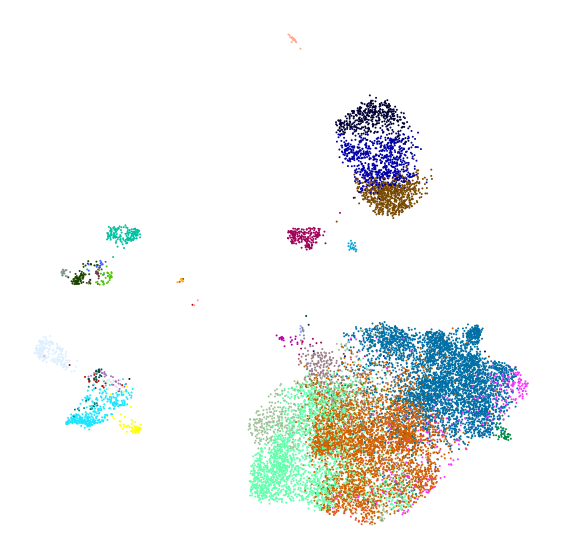

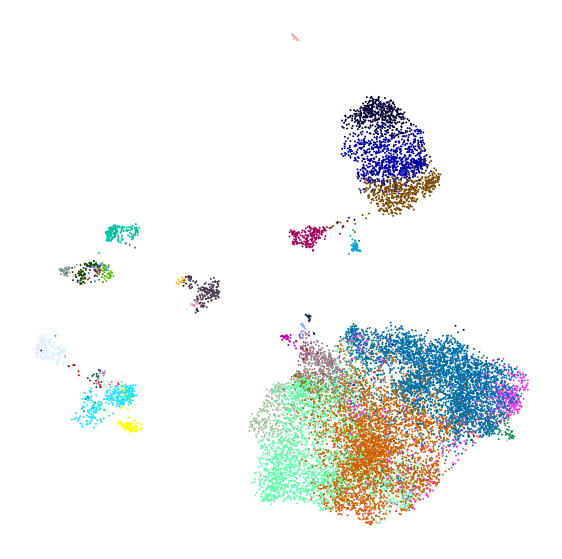

In [105]:
sc.pl.umap(adata_q[adata_q.obs['dataset_group'] == 'ctrl'], color='cell_annotation', 
           legend_loc='none', frameon=False, title='', save='ctrl_data_example.png')
sc.pl.umap(adata_q[adata_q.obs['dataset_group'] == 'query'], color='cell_annotation', 
           legend_loc='none', frameon=False, title='', save='query_data_example.png')

---

In [164]:
import matplotlib

def plot_milo_diagnostics(nhood_df, alpha = 0.1, figsize=[12, 12]):
    with matplotlib.rc_context({"figure.figsize": figsize}):

        ## Check P-value histogram
        plt.subplot(2, 2, 1)
        plt.hist(nhood_df["PValue"], bins=20)
        plt.xlabel("Uncorrected P-value")

        ## Visualize extent of multiple-testing correction
        plt.subplot(2, 2, 2)
        plt.scatter(nhood_df["PValue"], nhood_df["SpatialFDR"], s=3)
        plt.xlabel("Uncorrected P-value")
        plt.ylabel("SpatialFDR")

        ## Visualize volcano plot
        plt.subplot(2, 2, 3)
        plt.scatter(
            nhood_df["logFC"], -np.log10(nhood_df["SpatialFDR"]), s=3
        )
        plt.axhline(
            y=-np.log10(alpha),
            color="red",
            linewidth=1,
            label=f"{int(alpha*100)} % SpatialFDR",
        )
        plt.legend()
        plt.xlabel("log-Fold Change")
        plt.ylabel("- log10(SpatialFDR)")
        plt.tight_layout()

        ## Visualize MA plot
        df = nhood_df
        emp_null = df[df["SpatialFDR"] >= alpha]["logFC"].mean()
        df["Sig"] = df["SpatialFDR"] < alpha

        plt.subplot(2, 2, 4)
        sns.scatterplot(data=df, x="logCPM", y="logFC", hue="Sig")
        plt.axhline(y=0, color="grey", linewidth=1)
        plt.axhline(y=emp_null, color="purple", linewidth=1)
        plt.legend(title=f"< {int(alpha*100)} % SpatialFDR")
        plt.xlabel("Mean log-counts")
        plt.ylabel("log-Fold Change")
        plt.show()

/tmp/ipykernel_2198/1955241693.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Sig"] = df["SpatialFDR"] < alpha


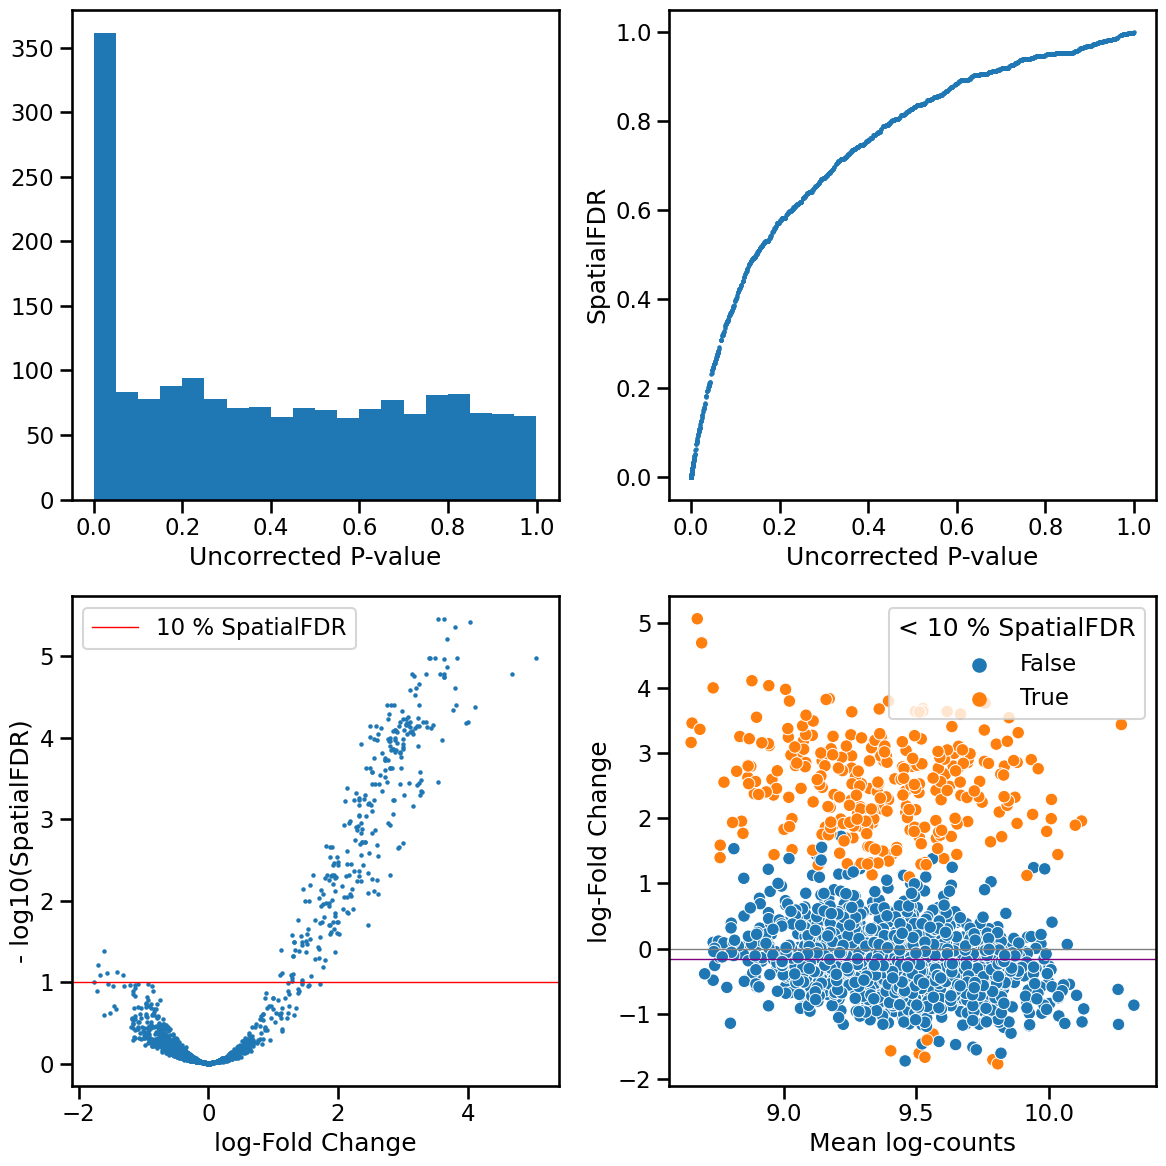

In [165]:
plot_milo_diagnostics(nhoods_df_all[(nhoods_df_all['design'] == 'CR') & (nhoods_df_all['OOR_state_name'] == 'Lymphatic_EC')])

In [167]:
mat = sc.metrics.confusion_matrix('Celltype_HLCA', 'sample_id', adata.obs, normalize=False)
mat.loc['Alveolar macrophages']

sample_id
001C        0
003C      329
022C-a      0
022C-b    269
065C        0
092C        0
098C-a    411
098C-b      0
133C-a      0
137C-a      0
137C-b    173
160C      631
192C-a      0
208C      166
218C-a     40
218C-b      0
219C-a      0
219C-b     21
222C      275
226C-a     48
226C-b      0
296C        0
388C      285
396C      594
439C      272
439C-b      0
454C       58
465C        0
483C        0
484C      247
Name: Alveolar macrophages, dtype: int64

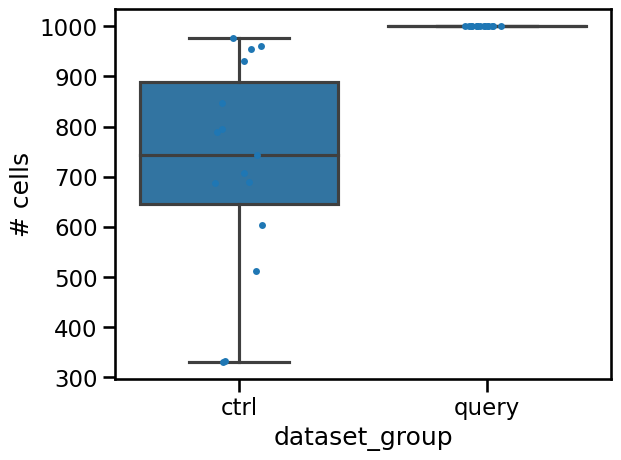

In [168]:
df = adata.obs[['dataset_group', 'sample_id']].value_counts().reset_index()
sns.boxplot(data=df, x='dataset_group', y=0);
sns.stripplot(data=df, x='dataset_group', y=0);
plt.ylabel('# cells');
plt.show()

In [83]:
adata.obs[['dataset_group', 'Library_Identity']].value_counts()

dataset_group  Library_Identity
query          226C-b              5570
ctrl           133C-a              5364
query          226C-a              5091
               098C-b              4753
               160C                4494
               439C-b              4492
               098C-a              4375
               003C                3415
ctrl           192C-a              3042
query          439C                2615
               465C                2610
ctrl           022C-a              2564
               022C-b              2341
query          137C-b              2292
               388C                2272
               137C-a              2249
               208C                2037
ctrl           296C                1736
               222C                1500
               065C                1453
               092C                1414
query          219C-b              1365
               219C-a              1344
               396C                1240
ctrl    

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


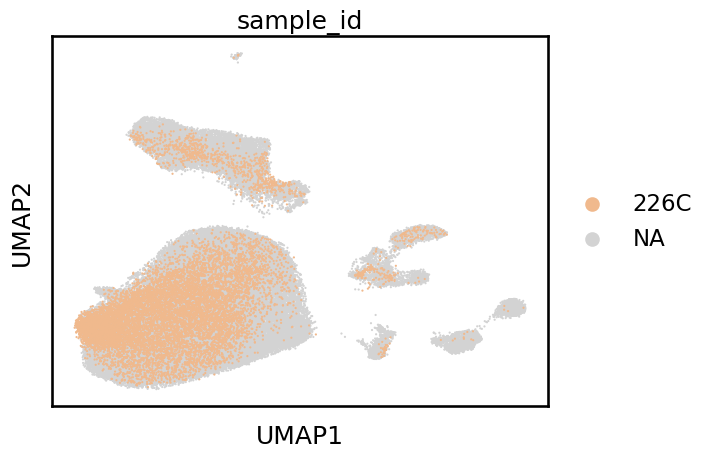

In [78]:
sc.pl.umap(adata, color='sample_id', groups='226C', size=10)

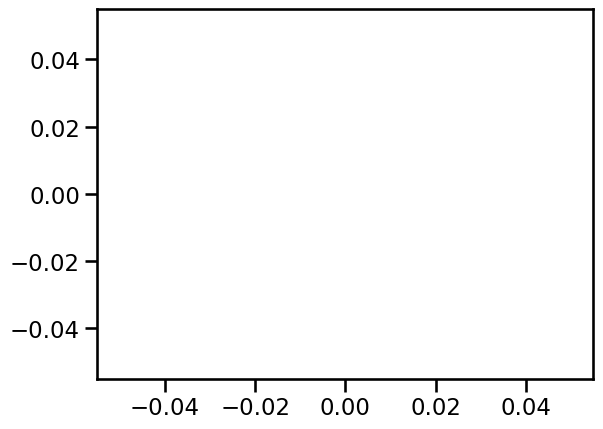

In [38]:
sns.stripplot(data=nhoods_df_all[nhoods_df_all['nhood_annotation'] == 'Alveolar macrophages'], x='logFC', y='SpatialFDR');
plt.show()

---

In [169]:
import milopy

In [170]:
simdir = '/lustre/scratch117/cellgen/team205/ed6/OOR_benchmark_lung/Kaminski2020_lung_cell_type_cleanAdventitial_fibroblasts_seed2025/'
adata = read_oor_design_output(simdir, ref_design='TabulaSapiens', population_obs='cell_type_clean')

Reading Adventitial_fibroblasts



In [171]:
sc.tl.umap(adata)

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


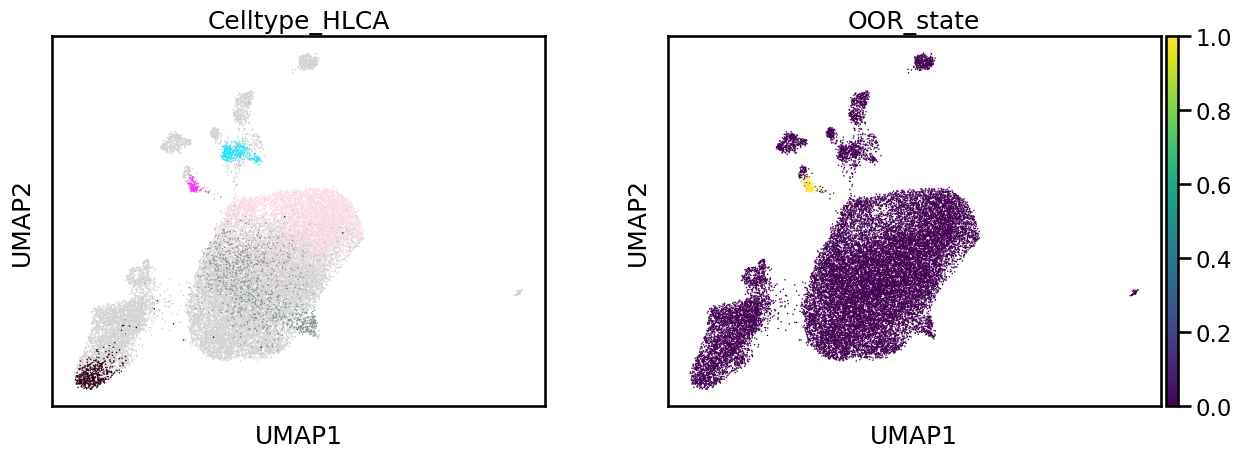

In [182]:
sc.pl.umap(adata, color=['Celltype_HLCA','OOR_state'], legend_loc='none', groups=oor_cts)

In [186]:
adata.obs[adata.obs["Celltype_HLCA"].isin(oor_cts)].value_counts(['dataset_group', 'Celltype_HLCA'])

dataset_group  Celltype_HLCA          
query          Alveolar macrophages       3819
               DC2                         603
               NK cells                    483
ctrl           DC2                         393
query          AT2                         314
               Adventitial fibroblasts     134
dtype: int64

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


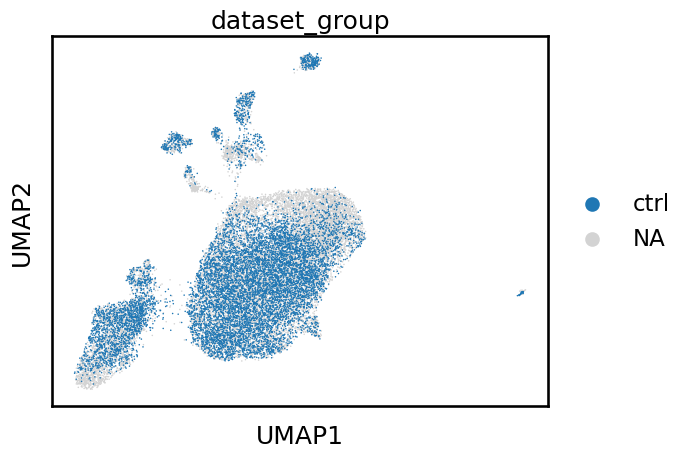

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


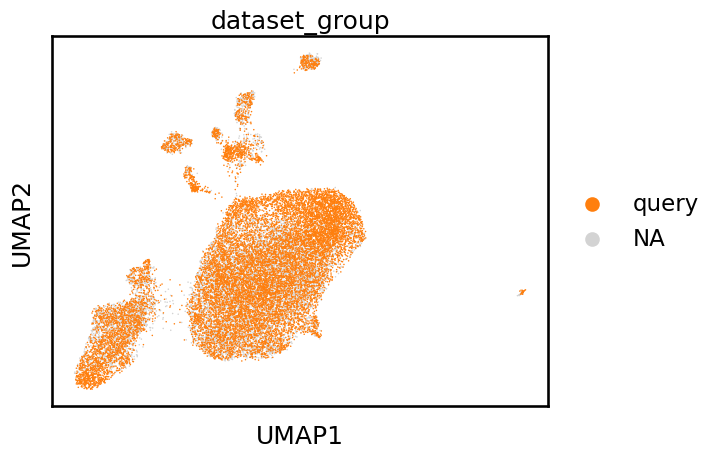

In [173]:
sc.pl.umap(adata, color='dataset_group', groups=['ctrl'])
sc.pl.umap(adata, color='dataset_group', groups=['query'])

In [174]:
conf_mat = sc.metrics.confusion_matrix('Celltype_HLCA','Library_Identity', adata.obs, normalize=False)
ct_abundance_adata = anndata.AnnData(X=conf_mat.T, obs=adata.uns['nhood_adata'].var)
sc.pp.pca(ct_abundance_adata)

/tmp/ipykernel_2198/4035286802.py:2: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  ct_abundance_adata = anndata.AnnData(X=conf_mat.T, obs=adata.uns['nhood_adata'].var)


In [175]:
ct_abundance_adata.obs['is_query'] = ct_abundance_adata.obs['is_query'].astype(str)

In [176]:
query_samples

array(['388C', '226C-a', '208C', '098C-a', '022C-b', '003C', '137C-b',
       '218C-a', '439C', '454C', '396C', '484C', '219C-b', '160C', '222C'],
      dtype=object)

In [177]:
adata.obs[['Subject_Identity', 'Library_Identity', 'dataset_group']].drop_duplicates().sort_values('Subject_Identity')

,Subject_Identity,Library_Identity,dataset_group
CellBarcode_Identity,,,
001C_CGGGTCACAGCCTTGG,001C,001C,ctrl
003C_ATCCACCTCACAAACC,003C,003C,query
065C_CGGACGTAGGCAATTA,065C,065C,ctrl
092C_CGATGGCAGTACGTAA,092C,092C,ctrl
098C-a_GTGTGCGAGACGCAAC,098C,098C-a,query
098C-b_GTCATTTGTACTTAGC,098C,098C-b,ctrl
133C-a_GTTCTCGAGTCGCCGT,133C,133C-a,ctrl
160C_CCTACACTCCGTAGGC,160C,160C,query
192C-a_AAAGTAGCAGGTCTCG,192C,192C-a,ctrl


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


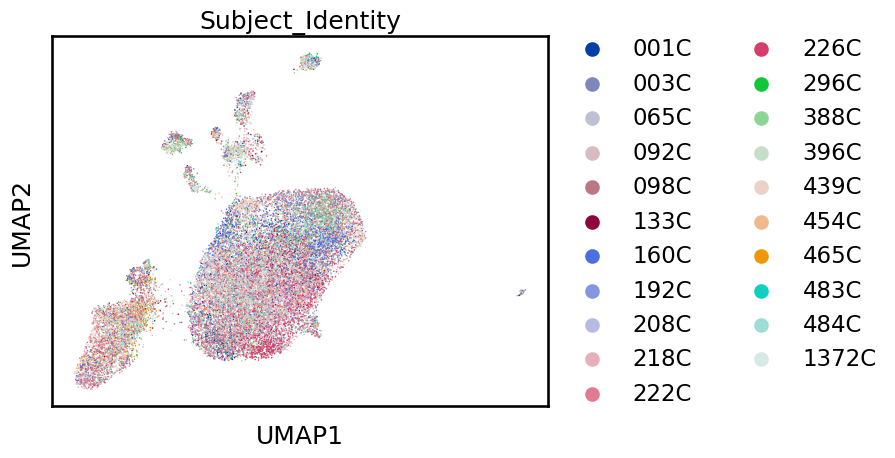

In [178]:
sc.pl.umap(adata, color='Subject_Identity')

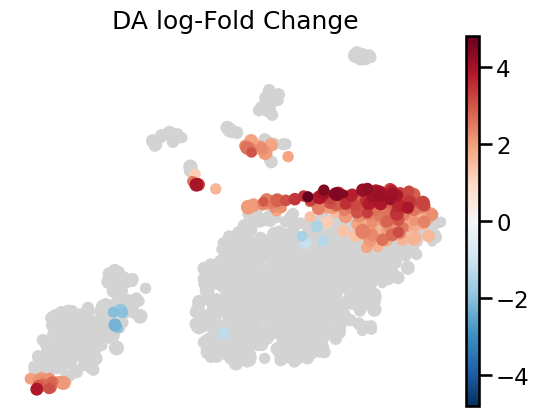

In [179]:
milopy.utils.build_nhood_graph(adata)
milopy.plot.plot_nhood_graph(adata, min_size=1)